## Regression Model
---

Suppose we have data $(y_1,x_1),\dots,(y_n,x_n)$. Let $u_i$ denote the error term for the $i$-th pair $(y_i,x_i)$, $(i=1,\dots,n)$. We assume each $u_i$ independently follows the normal distribution with mean 0 and variance $\sigma^2$. Then the regression model is given by

$$
 y_i = \alpha + \beta x_i + u_i,\quad u_i \sim \mathrm{Normal}(0,\sigma^2).
$$

where $\alpha$, $\beta$ and $\sigma^2$ are unknown parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from IPython.display import display

PyMC (https://www.pymc.io/welcome.html) is a Python package for Bayesian data analysis. Please read instructions at https://github.com/nakatsuma/probability_and_statistics before you install PyMC. It is a preferred practice to set up an independent environment for each project because it makes management of versions and dependencies much easier.


In [2]:
import pymc as pm

As a numerical illustration, we generate artificial data from a simple regression model.

$$
 y_i = 1 + 2 x_i + u_i,\quad u_i \sim \mathrm{Normal}(0, (0.7)^2).
$$

In this example, we generate $x_i$ from a uniform distribution over $[-\sqrt{3},\sqrt{3}]$ whose mean and variance are 0 and 1 respectively.

In [3]:
rng = np.random.default_rng(seed=99)
a, b, sigma, n = 1.0, 2.0, 0.7, 50
u = rng.normal(scale=sigma, size=n)
x = rng.uniform(low=-np.sqrt(3.0), high=np.sqrt(3.0), size=n)
y = a + b * x + u
X = np.stack((np.ones(n), x), axis=1)

The following cell plots the generated data.

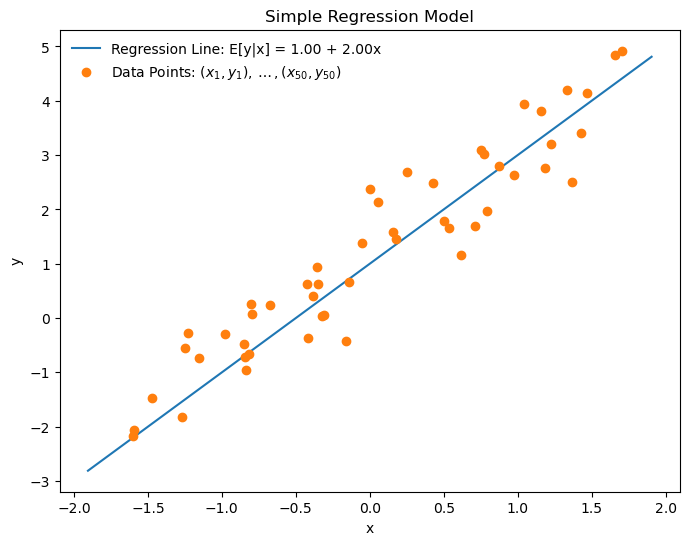

In [4]:
x_range = np.array([-1.1*np.sqrt(3.0), 1.1*np.sqrt(3.0)])
y_range = np.array([a + b*x_range[0], a + b*x_range[1]])
plt.figure(figsize=(8,6))
plt.plot(x_range, y_range, label=f'Regression Line: E[y|x] = {a:.2f} + {b:.2f}x')
plt.plot(x, y, 'o', label=f'Data Points: $(x_1,y_1),\dots,(x_{{{n}}},y_{{{n}}})$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Regression Model')
plt.legend(loc='upper left', frameon=False)
plt.show()

The prior distribution of $\alpha$, $\beta$ and $\sigma^2$ are

\begin{align*}
 \begin{bmatrix} \alpha \\ \beta \end{bmatrix}
 &\sim \mathrm{Normal}\left(
 \begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix},
 \begin{bmatrix} \sigma_{\alpha}^2 & 0 \\ 0 & \sigma_{\beta}^2 \end{bmatrix},
 \right), \\
 \sigma^2 &\sim \mathrm{Inv.Gamma}\left(\frac{\nu_0}{2},\frac{\lambda_0}{2}\right).
\end{align*}


In [5]:
mu_a, mu_b, sigma_a, sigma_b, nu0, lam0 = 0.0, 0.0, 10.0, 10.0, 0.02, 0.02

In PyMC, the model is defined by `with` statement. A general syntax of `with` is as follows.

```Python
with model_object:
    model specifications
```

`model_object` is either given by a PyMC function `Model` as

```Python
 model_object = pm.Model()
```

or defined in the `with` statement as

```Python
with pm.Model() as model_object:
```

These two lines define data variables `y_data`  and `x_data`.

``` Python
    y_data = pm.Data('y_data', y)
    x_data = pm.Data('x_data', x)
```

The following line specifies that `sigma2` follows the inverse gamma distribution, Inv.Gamma(0.5\*nu0, 0.5\*lam0).

```Python
sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
```

`'sigma2'` is the name of the variable.

These two lines specify that `a` and `b` follow the normal distributions, Normal(mu_a,omega_a\*\*2) and Normal(mu_b,omega_b\*\*2), respectively.

```Python
    a = pm.Normal('a', mu=mu_a, sigma=omega_a)
    b = pm.Normal('b', mu=mu_b, sigma=omega_b)
```

In the next line, we define the regression line `y_hat`.

```Python
    y_hat = a + b * x_data
```

Finally we specify the likelihood of the regression model.

```Python
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y_data)
```

The option `observed` specifies the data vector.


In [6]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    y_data = pm.Data('y_data', y)
    x_data = pm.Data('x_data', x)
    sigma2 = pm.InverseGamma('$\\sigma^2$', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('$\\alpha$', mu=mu_a, sigma=sigma_a)
    b = pm.Normal('$\\beta$', mu=mu_b, sigma=sigma_b)
    y_hat = a + b * x_data
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y_data)

A PyMC function `sample` generates a Monte Carlo sample of parameters from the posterior distribution. 

+ `draws` - number of draws per chain you generate from the posterior distribution
+ `chains` - number of chains you generate (`chains` \* `draws` = sample size)
+ `tune` - number of initial draws for tuning parameters in the sampler
+ `target_accept` - acceptance rate (higher is better, but it will take more computing time)
+ `random_seed` - seed of the pseudo-random number generator
+ `nuts_sampler` - sampling backend
+ `progressbar` - the progressbar is not displayed if `False`


In [7]:
n_draws, n_chains, n_tune = 5000, 4, 1000
with regresssion_normal_invgamma:
    # trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng) # PyMC default sampler (very slow)
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro') # numpyro (much faster but does not work on Colab)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

`summary` computes the posterior statistics with the Monte Carlo sample.

In [8]:
display(pm.summary(trace, hdi_prob=0.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\alpha$,1.174,0.087,1.006,1.347,0.001,0.001,17424.0,13359.0,1.0
$\beta$,1.855,0.091,1.674,2.032,0.001,0.001,17623.0,13281.0,1.0
$\sigma^2$,0.371,0.078,0.234,0.527,0.001,0.001,16996.0,13560.0,1.0


#### Effective Sample Size (ESS)

\begin{equation*}
 \hat T_{e} = \frac{T}{1+2\sum_{s=1}^S\hat\rho_s},
\end{equation*}

where	

\begin{equation*}
 \hat\rho_s = \frac{\hat\gamma_s}{\hat\gamma_0},\quad 
 \hat\gamma_s = \frac1{T}\sum_{t=s+1}^T(\theta_t-\bar\theta)(\theta_{t-s}-\bar\theta),\quad 
 \bar\theta = \frac1{T}\sum_{t=1}^T\theta_t.
\end{equation*}

#### Gelman-Rubin convergence diagnostic $\hat R$

\begin{equation*}
 \hat R =\sqrt{\frac{\hat V}{\hat W}},\quad 
 \hat V = \frac{n-1}{n}\hat W + \frac1{n}\hat B,
\end{equation*}
\begin{align*}
 \hat B &= \frac{n}{m-1}\sum_{j=1}^m(\bar\theta_{\cdot j}-\bar\theta)^2,\quad \bar\theta_{\cdot j} = \frac1{n}\sum_{i=1}^n\theta_{ij}, \\
 \hat W &= \frac1{m}\sum_{j=1}^m s_j^2,\quad s_j^2 = \frac1{n-1}\sum_{i=1}^n(\theta_{ij}-\bar\theta_{\cdot j})^2.
\end{align*}


`plot_trace` plots the Monte Carlo sample and draws the marginal posterior p.d.f. obtained with the kernel denisty estimation method.

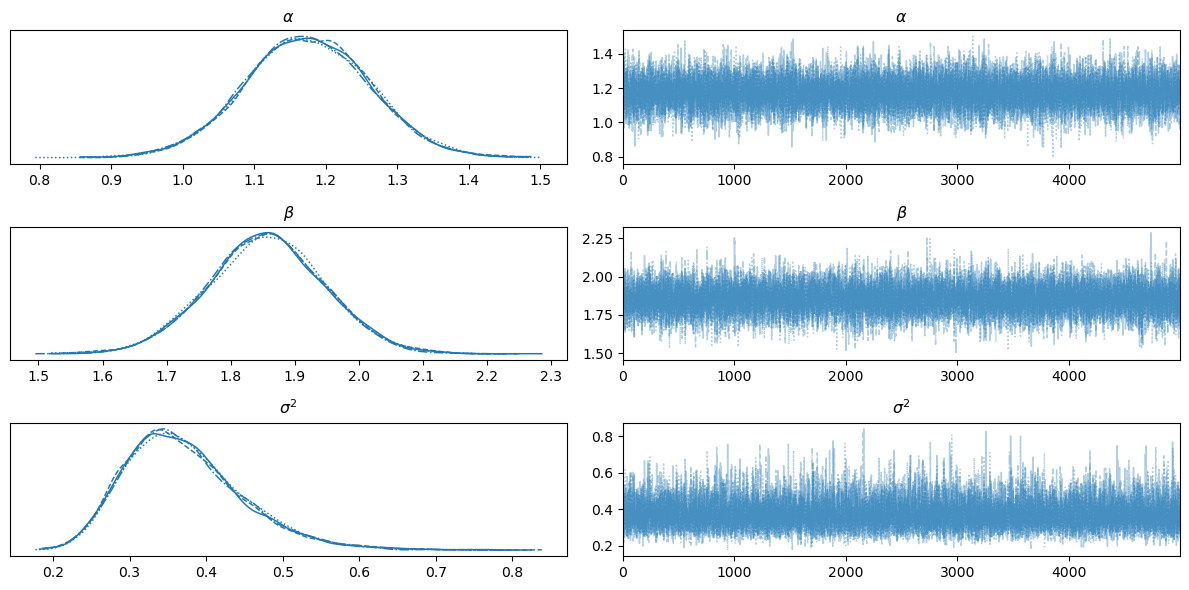

In [9]:
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

`plot_posterior` plots autocorrelations.

+ `max_lag` - the maximum number of lags
+ `combined` - combine all chains if `True`

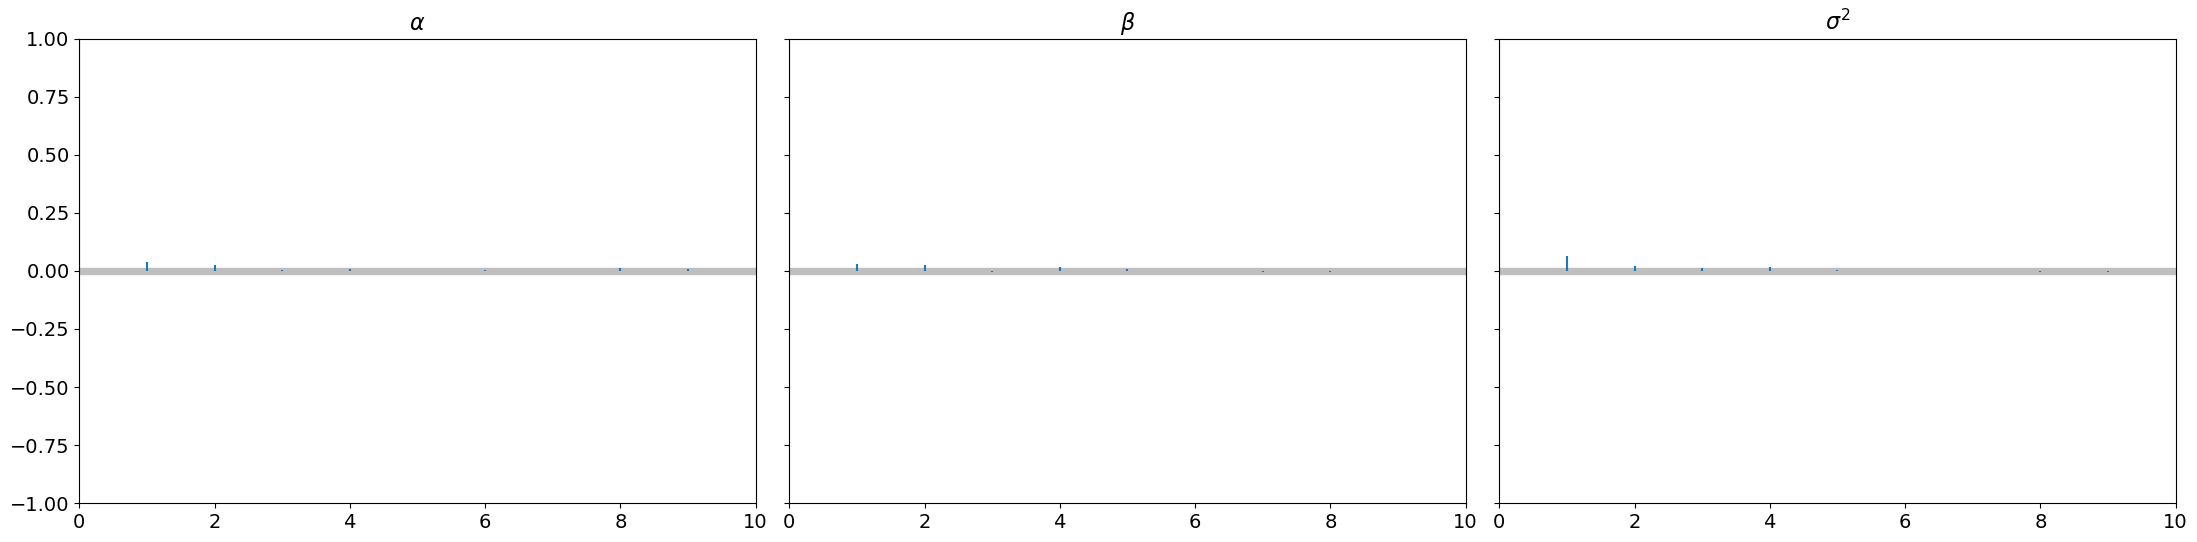

In [10]:
pm.plot_autocorr(trace, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

`plot_posterior` plots the marginal posterior p.d.f with the point estimate and the HPDI.

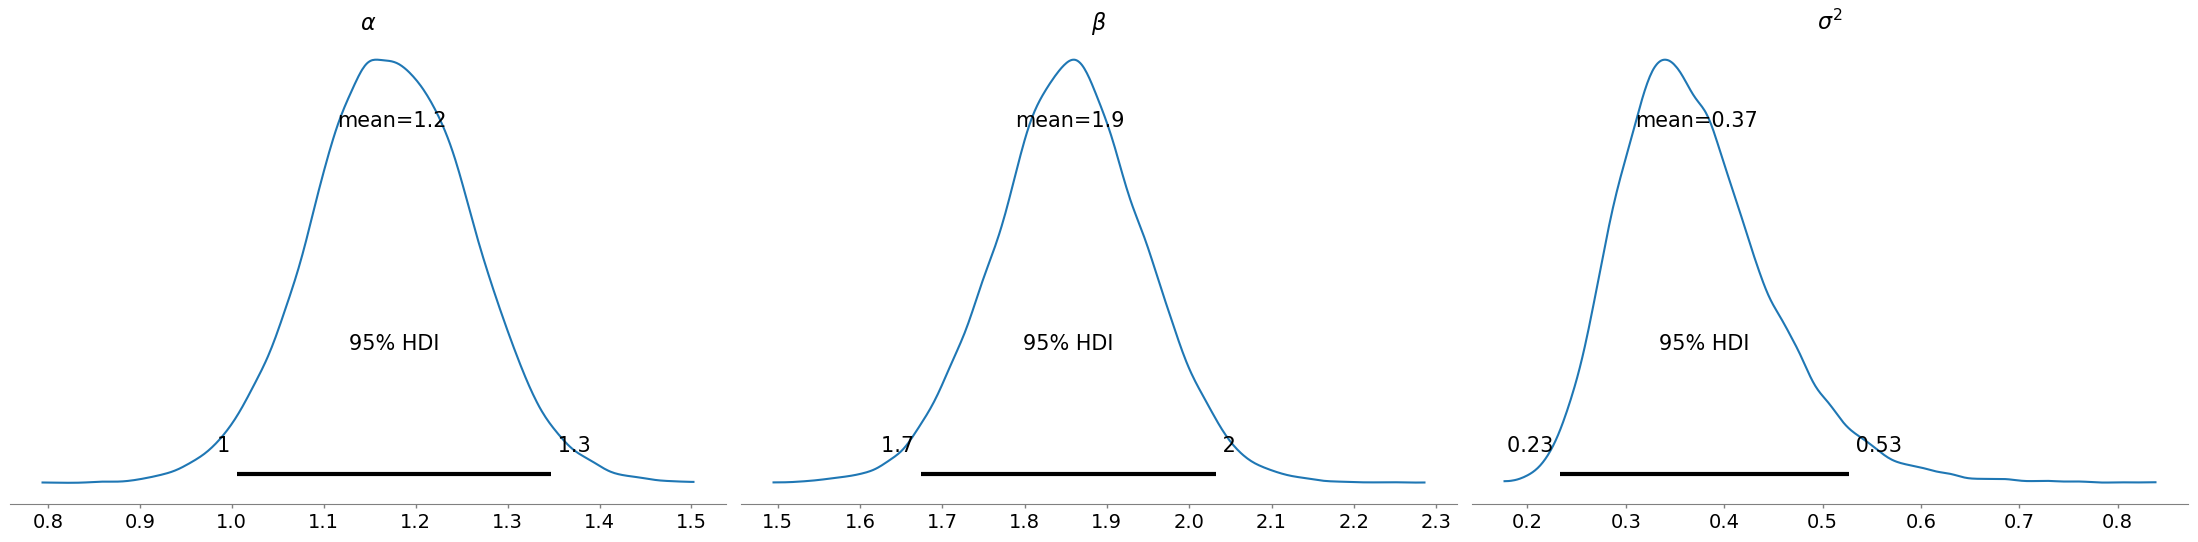

In [11]:
pm.plot_posterior(trace, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()